<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/%E5%84%AA%E8%89%AF%E3%82%A8%E3%83%83%E3%82%B8%E5%88%86%E5%B8%83%E3%81%AB%E5%AF%BE%E3%81%99%E3%82%8B%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%81%AE%E5%8A%B9%E6%9E%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 次のブロックは最初1度だけ実行すれ良い
日本語はランタイムの再起動時に有効になるので，実行後再起動

In [1]:
# 日本語フォントをダウンロードする。１度だけ実行
!apt-get -y install fonts-ipafont-gothic
# キャッシュを削除する。
!rm /root/.cache/matplotlib/fontlist-v300.json
# ランタイムを再起動する。

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 4 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 1s (7,581 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 130963 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-go

日本語フォントを有効にするために，一旦再起動してから以降を続けてください

In [1]:
%%bash
# 巡回セールスマン問題の最適解を求めるためのライブラリ　導入
cd /tmp
git clone https://github.com/jvkersch/pyconcorde
cd pyconcorde
pip install .
cd /content

Processing /tmp/pyconcorde
  Stored in directory: /tmp/pip-ephem-wheel-cache-vd1gjsbj/wheels/9b/c1/32/aa2663bd847e1c530e50377618e4c11fdaede88473fb7a4cb8
Successfully built pyconcorde
  Found existing installation: pyconcorde 0.1.0
    Uninstalling pyconcorde-0.1.0:
      Successfully uninstalled pyconcorde-0.1.0


fatal: destination path 'pyconcorde' already exists and is not an empty directory.


In [2]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
import seaborn as sns
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Conv2DTranspose,Concatenate
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.layers import add, concatenate
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, CSVLogger
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU
from keras.optimizers import Adam

from keras.utils import plot_model

import pickle

from keras.utils import to_categorical


Using TensorFlow backend.


# メモ
三木、榎原の論文では、頂点を描画半径1.5で描くとしているが、デジタル画像で　1.5　幅の円を描くとすれば、
1. ３×３の矩形とする
2.  １点を中心に上下左右とする
3.   １点を中心に４近傍は１、８近傍は 200（≒255*3.14/4) とする
あたりで近似せざるをえない。

とりあえず、３の方法を採ることにする。


In [0]:
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path

XSIZE = 192
YSIZE = 192
MSIZE = 2 # 周辺にとるマージン 

# 巡回する点を生成する関数
def genTSP(pnum = 3, xsize=XSIZE,ysize=YSIZE, msize = MSIZE):
    
    # 訪問地点を指定数　（pnum）重複なく生成　ただし周辺は避ける
    posnumA,  posA = [], []
    while len(posnumA)<pnum:
        a = np.random.randint(0,(xsize-2*msize)*(ysize-2*msize))
        if a not in posnumA:
            posnumA.append(a)
            y = a//(xsize-2*msize)+msize
            x = a%(xsize-2*msize)+msize
            posA.append([x,y])
 
     #  画像の生成  
    tspimg = np.zeros((ysize,xsize),np.uint8) # 問題となる画像　　
    refimg = np.ones((ysize,xsize,3),np.uint8)*100  # 表示用の画像

    # 選ばれた点を描
    for [x,y] in posA:
        timg = tspimg[y-1:y+2,x-1:x+2]  # 点が隣接していて重なる場合、明るい方の色で描くことにする
        tspimg[y-1:y+2,x-1:x+2] = np.bitwise_or(timg, np.array([[200,255,200],[255,255,255],[200,255,200]]))
        refimg = cv2.circle(refimg,(x,y),2,(0,255,255),-1)  # 表示用の方は少し誇張して描く
        
    return np.array(posA),tspimg,refimg

Text(0.5, 1.0, '巡回地点マップ')

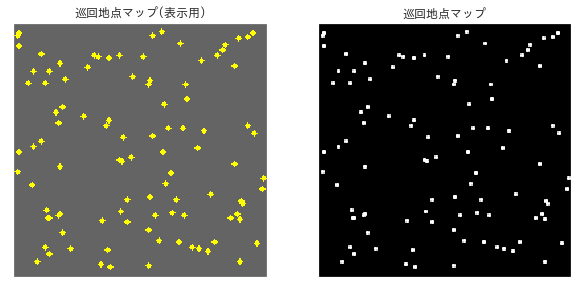

In [5]:
# 動作確認
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# jp_font = {'fontname':'IPAGothic'}
sns.set(font='IPAGothic')
_,tspimg,refimg = genTSP(100)
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(refimg[:,:,::-1])
plt.title("{}".format("巡回地点マップ(表示用)"))
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(tspimg)
plt.gray()
plt.title("{}".format("巡回地点マップ"))

# TSPの学習用データの生成（concorde法）
- https://github.com/jvkersch/pyconcorde のプログラムを使わせていただく

In [0]:
# !git clone https://github.com/jvkersch/pyconcorde
# % cd pyconcorde
# !pip install -e .

# Concorde TSP Solver の動作確認

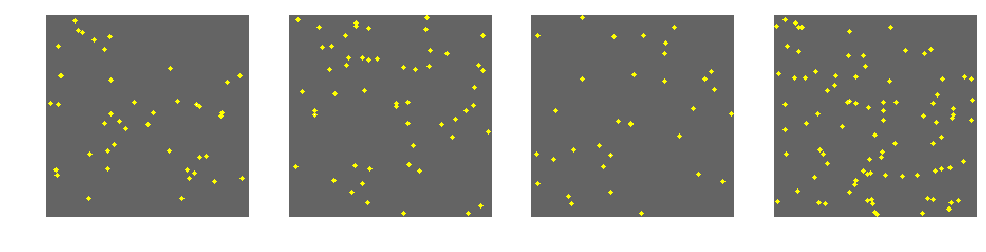

In [6]:
plt.figure(figsize=(12, 6), dpi=100)
for i in range(4):
    plt.subplot(1, 4, i+1)
    poss, img, rimg = genTSP(pnum=np.random.randint(20,100),xsize=XSIZE,ysize=YSIZE,msize=2)
    xs = [x for [x,y] in poss]
    ys = [y for [x,y] in poss]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    ps = solution.tour
    cv2.line(rimg,(xs[ps[0]],ys[ps[0]]),(xs[ps[-1]],ys[ps[-1]]),(255,255,255),1)
    p0 = ps[0]
    for p1 in ps[1:]:
        cv2.line(rimg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),(255,255,255),1)
        p0 = p1
    plt.imshow(rimg[:,:,::-1])
    plt.axis('off')

# TSPの問題画像と解画像の生成

In [0]:
XSIZE,YSIZE,MSIZE = 192,192, 2
minP = 20
maxP = 100

# TSPの問題と答えの生成(1セット) 
def genTSPSample(minP, maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    plist, img, _rimg = genTSP(pnum=np.random.randint(minP,maxP),xsize=XSIZE,ysize=YSIZE,msize=MSIZE)

    # TSP の最適解を求める
    xs = [x for [x,y] in plist]  # X座標のみのリスト
    ys = [y for [x,y] in plist]  # Y座標のみのリスト
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    tspsol = solution.tour # インデックス表現した解
    
    # 解画像を生成する
    simg = np.zeros_like(img)
    cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[tspsol[-1]],ys[tspsol[-1]]),255,1)
    p0 = tspsol[0]
    for p1 in tspsol[1:]:
        simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
        p0 = p1

    return (plist, tspsol, img, simg)

# TSPの解と正解のペアを指定数生成する関数

XSIZE,YSIZE,MSIZE = 192,192, 2
minP = 20  # 地点数の最小値
maxP = 100 # 地点数の最大値

def genTSPSamples(num = 100, minP = minP, maxP = maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    data = []  
    for i in range(num):
        data.append(genTSPSample(minP=minP, maxP=maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE))
    return data


# 訓練例の生成
せっかく作ったデータなので，google drive にも保存しておくことにする

In [0]:
%%time

SETNUM = 2

for i in range(SETNUM):
    pset = genTSPSamples(1000)
    f = open('/gdrive/My Drive/test1000_'+str(i),'wb')
    pickle.dump(pset,f)
    f.close

CPU times: user 3min 21s, sys: 24.2 s, total: 3min 45s
Wall time: 3min 57s


## google drive からのデータの読み込み 

In [40]:
%%time
f1 = open('/gdrive/My Drive/test1000_0','rb')
f2 = open('/gdrive/My Drive/test1000_1','rb')
train = pickle.load(f1)
testdata = pickle.load(f2)
f1.close
f2.close

CPU times: user 95.4 ms, sys: 132 ms, total: 227 ms
Wall time: 291 ms


## 読み込みデータの確認

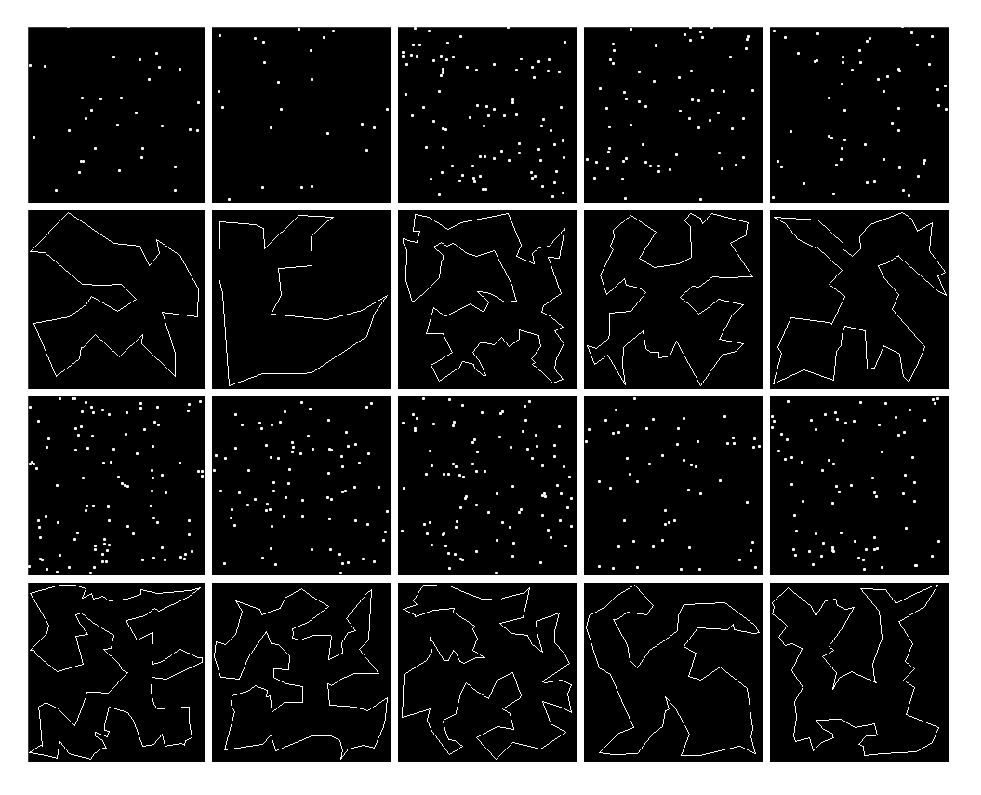

In [41]:
plt.figure(figsize=(6, 12), dpi=200)
simg = np.ones((800,1000),np.uint8)*255
for j in range(5):
    i = 0
    simg[400*i:400*i+192,200*j:200*j+192] = cv2.resize(train[5*i+j][2],(192,192))
    simg[400*i+200:400*i+392,200*j:200*j+192] = cv2.resize(train[5*i+j][3],(192,192))
    i = 1
    simg[400*i:400*i+192,200*j:200*j+192] = cv2.resize(testdata[5*i+j][2],(192,192))
    simg[400*i+200:400*i+392,200*j:200*j+192] = cv2.resize(testdata[5*i+j][3],(192,192))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(simg)

# ローカルミニマ

192x192に対し，20～100点だと平均経路長がいくらになるかはわからないが，1000～2000程度だとして95％～が黒であるから，常に真っ黒の画像を出力しても正答率は95％程度となってしまう．

何度か試したところ，ただちにaccuracy 0.9725,  loss 0.0278に収束するケースが多々あった．それは全部が出力０，真っ黒の画像となっていることを意味する．そうなったらあきらめて設定を変えるしかない．

もちろんローカルミニマに陥るかどうか，収束値がいくらであるかはデータセット次第である．


# 論文通りのCNNモデル
1点だけ変更　入出力データを０～１に正規化   
そうしないと標準の　Adam 最適化器のデフォルト設定では即発散し，かといって係数を小さくとるとローカルミニマにとらわれる．

In [10]:
K5 = (5,5)
K6 = (6,6)
K7 = (7,7)
K8 = (8,8)
slope_co = 0.2 # 0ならReLU

input = Input(shape=(192,192,1))
# Layer 1  (192,192,1) -> strides1 -> (192,192,32)
conv1 = Conv2D(32, K5, padding='same', strides=1)(input)
#conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (192,192,32) -> strides2 -> (96,96,32)
conv2 = Conv2D(32, K6, strides=2,padding='same')(conv1)
#conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (96,96,32) -> strides1 -> (96,96,64)
conv3 = Conv2D(64, K5, strides=1, padding='same')(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (96,96,64) -> strides2 -> (48,48,64)
conv4 = Conv2D(64, K8, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (48,48,64) -> strides1 -> (48,48,96)
conv5 = Conv2D(96, K7, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (48,48,96) -> strides2 -> (24,24,96)
conv6 = Conv2D(96, K8, strides=2, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (24,24,96) -> strides1 -> (24,24,128)
conv7 = Conv2D(128, K7, strides=1, padding='same')(conv6)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (24,24,128) -> strides2 -> (12,12,128)
conv8 = Conv2D(128, K8, strides=2, padding='same')(conv7)
conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (12,12,128) -> strides1 -> (12,12,160+128)
conv9 = Conv2D(160, K7, strides=1, padding='same')(conv8)
conv9 = LeakyReLU(alpha=slope_co)(conv9)
conv9 = concatenate([conv8,conv9])

# Layer 10 UP (12,12,160+128) -> strides2 -> (24,24,160)
conv10 = Conv2DTranspose(160, K8, strides=2, padding='same')(conv9)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (24,24,160) -> strides1 -> (24,24,128+128)
conv11 = Conv2D(128, K7, strides=1, padding='same')(conv10)
conv11 = LeakyReLU(alpha=slope_co)(conv11)
conv11 = concatenate([conv7,conv11])

# Layer 12 UP (24,24,128+128) -> strides2 -> (48,48,128)
conv12 = Conv2DTranspose(128, K8, strides=2, padding='same')(conv11)
conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (48,48,128) -> strides1 -> (48,48,96+96)
conv13 = Conv2D(96, K7, strides=1, padding='same')(conv12)
conv13 = LeakyReLU(alpha=slope_co)(conv13)
conv13 = concatenate([conv5,conv13])

# Layer 14 UP (48,48,96+96) -> strides2 -> (96,96,96)
conv14 = Conv2DTranspose(128, K8,strides=2, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)

# Layer 15  (96,96,96) -> strides1 -> (96,96,64+64)
conv15 = Conv2D(64, K7, strides=1 ,padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)
conv15 = concatenate([conv3,conv15])

# Layer 16 UP (96,96,64+64) -> strides2 -> (192,192,64)
conv16 = Conv2DTranspose(64, K6, strides=2, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (192,192,64) -> strides1 -> (192,192,32)
conv17 = Conv2D(32, K5, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)

# Layer 18  (192,192,32) -> strides1 -> (192,192,1)
output = Conv2D(1, K5, strides=1, padding='same')(conv17)
# output = Activation('hard_sigmoid')(output)

# Model

orig_model = Model(input,output)

orig_model.summary()

W0709 04:11:57.271246 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 04:11:57.300017 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 04:11:57.305743 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 192, 192, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   36896       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

# モデルの可視化

/content


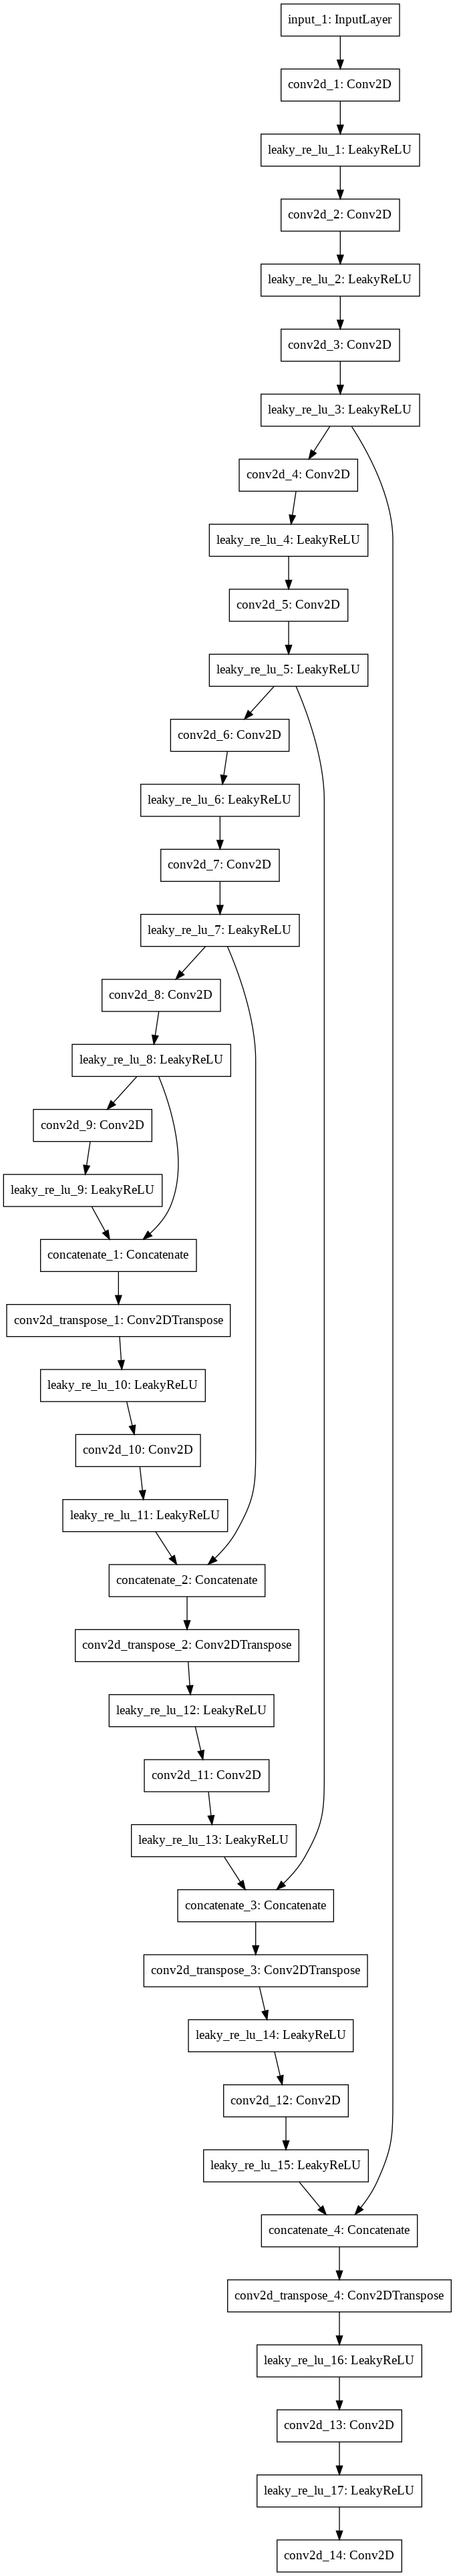

In [11]:
from IPython.display import Image, display_png
%cd /content
#学習モデル図の作成
plot_model(orig_model, to_file='orig_model.png')
display_png(Image('orig_model.png'))

# 論文に記述のない変更点

- Adamの学習係数をデフォルトの１０分の１とする．デフォルトは0.001 → 0.0001
- 入出力を０～１に正規化

## メモ
最終段の活性化関数を恒等変換とするとのことであるが，その意味がいまいちわからない．かといって，0～1となるよう sigmoid を使うと，あらゆる入力に対して常に真っ黒の画像を答えるような回路に収束してしまう．解画像の白画素が常に少ないので，常に黒と答えても97％程度の正解率となるのだからそれももっともである．

In [12]:
orig_model.compile(loss= 'mean_squared_error',#  'binary_crossentropy',#   # 'binary_crossentropy', # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0709 04:12:31.776498 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
Xex = np.array([x[2] for x in train])
Yex = np.array([y[3] for y in train])

dsize = len(Xex)
batch_size = 25
epochs = 100

X1 = np.array(Xex).reshape(dsize,192*192).astype('float32')
X1 = X1/255
X1 = X1.reshape(-1,192,192,1)
Y1 = np.array(Yex).reshape(dsize,192*192).astype('float32')
Y1 = Y1/255
Y1 = Y1.reshape(-1,192,192,1)

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = orig_model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.2, # 20 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])

W0709 04:12:39.728977 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0709 04:12:40.322948 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 30s 38ms/step - loss: 0.0257 - acc: 0.9722 - val_loss: 0.0251 - val_acc: 0.9721
Epoch 2/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0247 - acc: 0.9728 - val_loss: 0.0246 - val_acc: 0.9736
Epoch 3/100
800/800 [==============================] - 21s 26ms/step - loss: 0.0238 - acc: 0.9738 - val_loss: 0.0230 - val_acc: 0.9738
Epoch 4/100
800/800 [==============================] - 22s 28ms/step - loss: 0.0222 - acc: 0.9741 - val_loss: 0.0215 - val_acc: 0.9743
Epoch 5/100
800/800 [==============================] - 22s 28ms/step - loss: 0.0208 - acc: 0.9748 - val_loss: 0.0202 - val_acc: 0.9752
Epoch 6/100
800/800 [==============================] - 22s 27ms/step - loss: 0.0196 - acc: 0.9759 - val_loss: 0.0192 - val_acc: 0.9761
Epoch 7/100
800/800 [==============================] - 22s 27ms/step - loss: 0.0187 - acc: 0.9771 - val_loss: 0.0183 - val_acc: 0.9777
Epoch 8/1

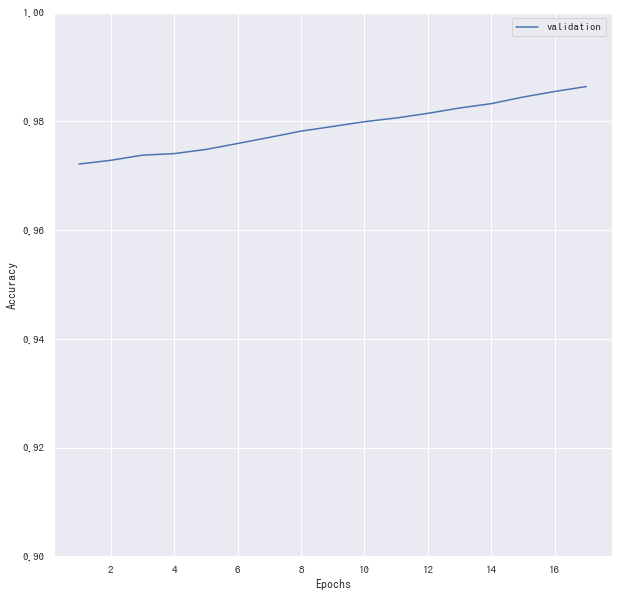

In [14]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

# テストデータでも経路っぽい出力がでるかどうか確認

1.3497041
1.3803705
1.2020322
1.3930998
1.4005715


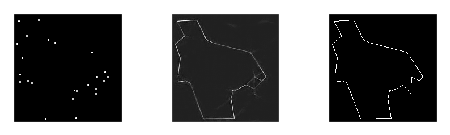

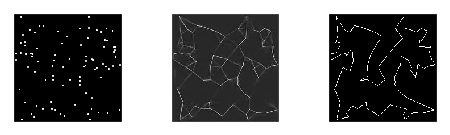

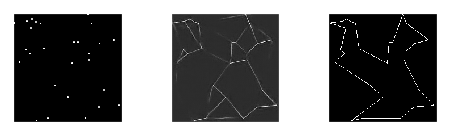

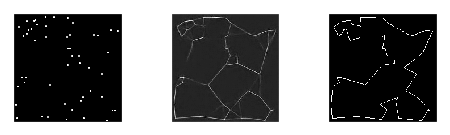

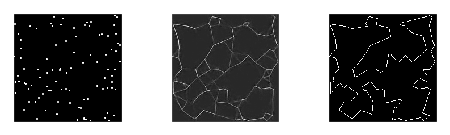

In [16]:
Xtex = np.array([x[2] for x in testdata[:5]])
Ytex = np.array([y[3] for y in testdata[:5]])

def test(X,Y,i):
    output = orig_model.predict(X[i].reshape(-1,192,192,1)/255)
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(192,192)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X[i],cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    print(output.max())
    output = output
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y[i],cmap=plt.cm.binary)
for i in range(5):
    test(Xtex,Ytex,i)

In [0]:
# 正規化
# 主成分がX軸となるように回転し，重心をセンターに移動，192x192に収める．
import math

def normalizePos(poslist):
    mn = np.mean(poslist,axis=0) # 重心
    posB = poslist - mn # 重心を原点に移動
    cv = np.cov(posB[:,0],posB[:,1],bias=1) # 共分散行列
    W, v = np.linalg.eig(cv) # 固有ベクトルと固有値を計算
    # print(W,v)
    if np.abs(W[0]) > np.abs(W[1]):
        angle = math.atan2(v[1,0],v[0,0]) 
    else:
        angle = math.atan2(v[1,1],v[0,1])
    # print(angle)
    posC = [[x*np.cos(-angle)-y*np.sin(-angle), x*np.sin(-angle)+y*np.cos(-angle)] for [x,y] in posB]
    maxXY = np.max(posC,axis=0)
    minXY = np.min(posC,axis=0)
    posD = posC
    flipX, flipY = False, False
    if maxXY[0] < -minXY[0]:
        flipX = True
        posD = [[-x,y] for [x,y] in posD]
    if maxXY[1] < -minXY[1]:
        flipY = True
        posD = [[x,-y] for [x,y] in posD]
    maxXY = np.max(posD,axis=0)
    minXY = np.min(posD,axis=0)
    xband = np.max([2*maxXY[0],-2*minXY[0],2*maxXY[1],-2*minXY[1]])
    posD = [[int(x*180/xband)+96,int(y*180/xband)+96] for [x,y] in posD]
    return posD, angle, flipX, flipY

# 巡回する点を生成する関数
def normalizeData(dataset):
    dataset2=[]
    for (posA,_1,_2,_3) in dataset:
        posA, _a, _f1,_f2 = normalizePos(posA)
        #  画像の生成  
        tspimg = np.zeros((192,192),np.uint8) # 問題となる画像　　

        # 選ばれた点を描く
        for [x,y] in posA:
            timg = tspimg[y-1:y+2,x-1:x+2]  # 点が隣接していて重なる場合、明るい方の色で描くことにする
            tspimg[y-1:y+2,x-1:x+2] = np.bitwise_or(timg, np.array([[200,255,200],[255,255,255],[200,255,200]]))
        
        # TSP の最適解を求める
        xs = [x for [x,y] in posA]  # X座標のみのリスト
        ys = [y for [x,y] in posA]  # Y座標のみのリスト
        solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
        solution = solver.solve()
        tspsol = solution.tour # インデックス表現した解
    
        # 解画像を生成する
        simg = np.zeros_like(tspimg)
        cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[tspsol[-1]],ys[tspsol[-1]]),255,1)
        p0 = tspsol[0]
        for p1 in tspsol[1:]:
            simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
            p0 = p1
        
        dataset2.append((posA, tspsol, tspimg, simg))
    return dataset2
    

In [0]:
train2 = normalizeData(train)
testdata2 = normalizeData(testdata)

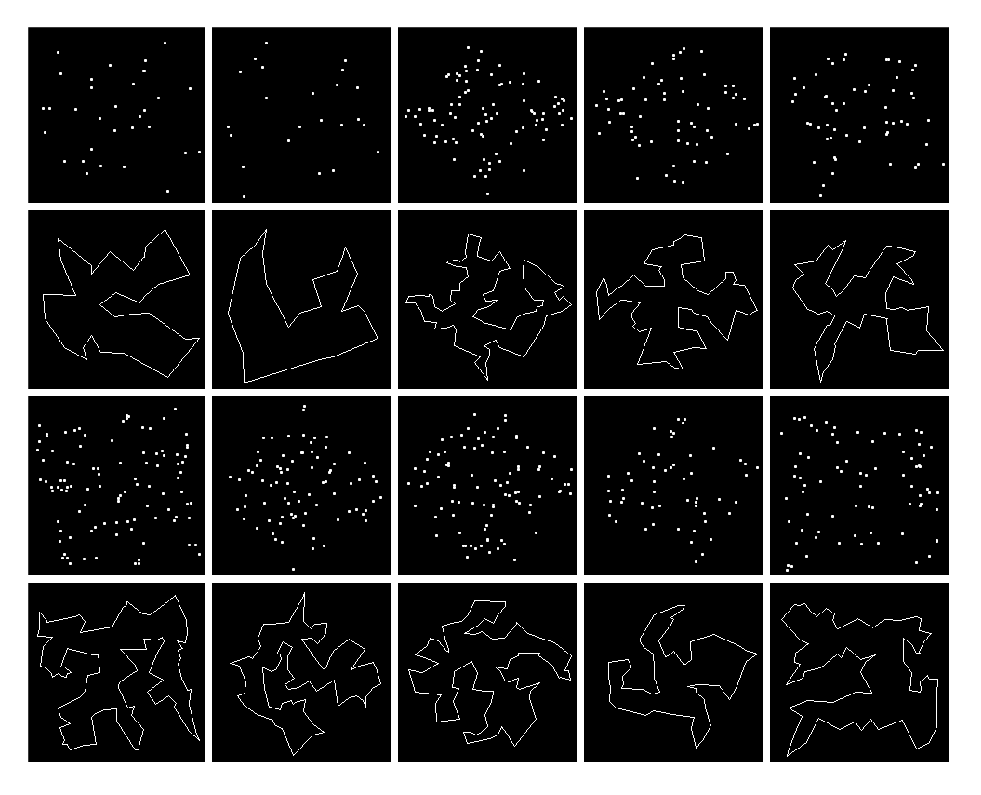

In [115]:
plt.figure(figsize=(6, 12), dpi=200)
simg = np.ones((800,1000),np.uint8)*255
for j in range(5):
    i = 0
    simg[400*i:400*i+192,200*j:200*j+192] = train2[5*i+j][2]
    simg[400*i+200:400*i+392,200*j:200*j+192] = train2[5*i+j][3]
    i = 1
    simg[400*i:400*i+192,200*j:200*j+192] = testdata2[5*i+j][2]
    simg[400*i+200:400*i+392,200*j:200*j+192] = testdata2[5*i+j][3]
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(simg)

In [0]:
orig_model.compile(loss= 'mean_squared_error',#  'binary_crossentropy',#   # 'binary_crossentropy', # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

In [122]:
Xex = np.array([x[2] for x in train2])
Yex = np.array([y[3] for y in train2])

dsize = len(Xex)
batch_size = 25
epochs = 100

X1 = np.array(Xex).reshape(dsize,192*192).astype('float32')
X1 = X1/255
X1 = X1.reshape(-1,192,192,1)
Y1 = np.array(Yex).reshape(dsize,192*192).astype('float32')
Y1 = Y1/255
Y1 = Y1.reshape(-1,192,192,1)

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = orig_model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.2, # 20 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0117 - acc: 0.9859 - val_loss: 0.0112 - val_acc: 0.9864
Epoch 2/100
800/800 [==============================] - 21s 26ms/step - loss: 0.0109 - acc: 0.9869 - val_loss: 0.0110 - val_acc: 0.9866
Epoch 3/100
800/800 [==============================] - 21s 27ms/step - loss: 0.0104 - acc: 0.9875 - val_loss: 0.0110 - val_acc: 0.9866
Epoch 4/100
800/800 [==============================] - 22s 28ms/step - loss: 0.0099 - acc: 0.9883 - val_loss: 0.0111 - val_acc: 0.9864
Epoch 5/100
800/800 [==============================] - 22s 27ms/step - loss: 0.0094 - acc: 0.9890 - val_loss: 0.0113 - val_acc: 0.9863


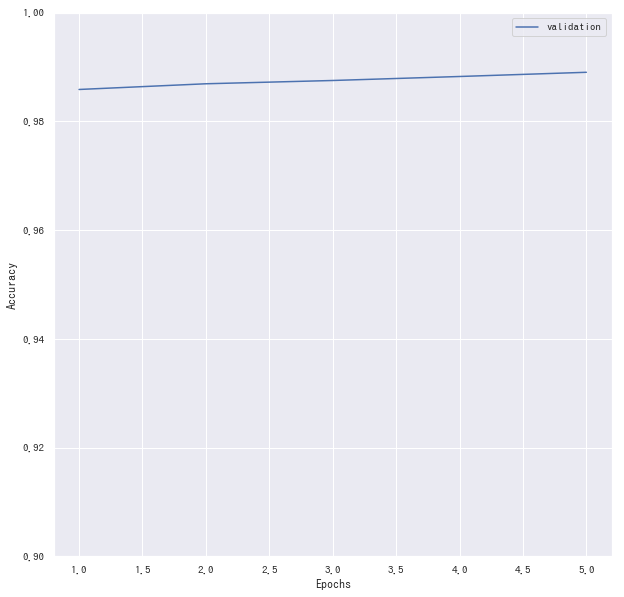

In [123]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

1.2043738
1.3932201
1.4365283
1.1720196
1.2866199


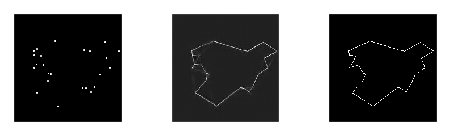

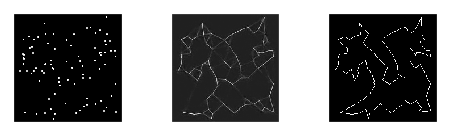

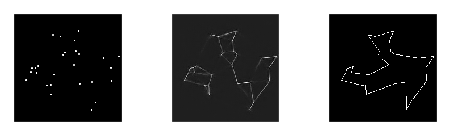

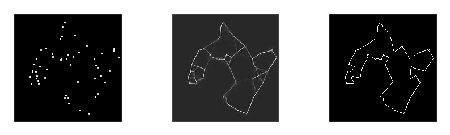

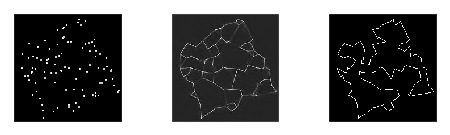

In [124]:
Xtex = np.array([x[2] for x in testdata2[:5]])
Ytex = np.array([y[3] for y in testdata2[:5]])

def test(X,Y,i):
    output = orig_model.predict(X[i].reshape(-1,192,192,1)/255)
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(192,192)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X[i],cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    print(output.max())
    output = output
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y[i],cmap=plt.cm.binary)
for i in range(5):
    test(Xtex,Ytex,i)

1.3519388
1.2493134
1.3070277
1.3685986
1.4156753


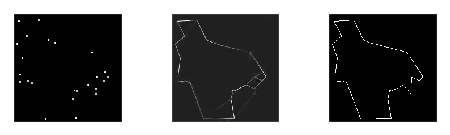

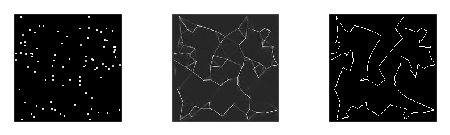

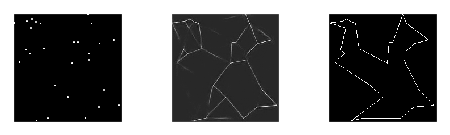

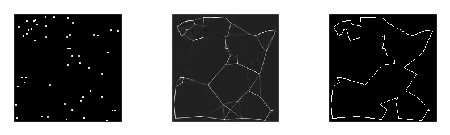

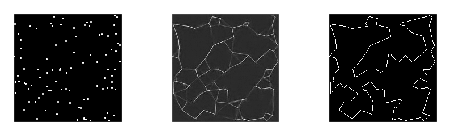

In [125]:
Xtex = np.array([x[2] for x in testdata[:5]])
Ytex = np.array([y[3] for y in testdata[:5]])

def test(X,Y,i):
    output = orig_model.predict(X[i].reshape(-1,192,192,1)/255)
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(192,192)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X[i],cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    print(output.max())
    output = output
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y[i],cmap=plt.cm.binary)
for i in range(5):
    test(Xtex,Ytex,i)

# My CNNモデル
榎原論文との違い
1. LeakyReLU ではなく普通の ReLU
2. 圧縮の最終段（１２x１２となるところ）にBatchNormalization を挿入
3. 入出力を/255 して０～１に

- LeakyReLU を採用しておられるのには何か理由があるのだろうけれど，わからないので ReLUではだめなのか試す
- BatchNormalization や Drop が使われていないので入れてみた．BatchNormalization を入れると収束が早く，振動や発散しにくくなるといわれている．

In [0]:
# データの読み込み
%%time
f1 = open('/gdrive/My Drive/test1000_0','rb')
f2 = open('/gdrive/My Drive/test1000_1','rb')
train = pickle.load(f1)
testdata = pickle.load(f2)
f1.close
f2.close

# モデル定義

In [121]:
K5 = (5,5)
K6 = (6,6)
K7 = (7,7)
K8 = (8,8)
slope_co = 0.0

input = Input(shape=(192,192,1))

# Layer 1  (192,192,1) -> strides1 -> (192,192,32)
conv1 = Conv2D(32, K5, padding='same', strides=1)(input)
#conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (192,192,32) -> strides2 -> (96,96,32)
conv2 = Conv2D(32, K6, strides=2,padding='same')(conv1)
#conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (96,96,32) -> strides1 -> (96,96,64)
conv3 = Conv2D(64, K5, strides=1, padding='same')(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (96,96,64) -> strides2 -> (48,48,64)
conv4 = Conv2D(64, K8, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (48,48,64) -> strides1 -> (48,48,96)
conv5 = Conv2D(96, K7, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (48,48,96) -> strides2 -> (24,24,96)
conv6 = Conv2D(96, K8, strides=2, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (24,24,96) -> strides1 -> (24,24,128)
conv7 = Conv2D(128, K7, strides=1, padding='same')(conv6)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (24,24,128) -> strides2 -> (12,12,128)
conv8 = Conv2D(128, K8, strides=2, padding='same')(conv7)
conv8 = BatchNormalization()(conv8)
conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (12,12,128) -> strides1 -> (12,12,160)
conv9 = Conv2D(160, K7, strides=1, padding='same')(conv8)
conv9 = LeakyReLU(alpha=slope_co)(conv9)
conv9 = concatenate([conv8,conv9])

# Layer 10 UP (12,12,160) -> strides2 -> (24,24,160)
conv10 = Conv2DTranspose(160, K8, strides=2, padding='same')(conv9)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (24,24,160) -> strides1 -> (24,24,128)
conv11 = Conv2D(128, K7, strides=1, padding='same')(conv10)
conv11 = LeakyReLU(alpha=slope_co)(conv11)
conv11 = concatenate([conv7,conv11])

# Layer 12 UP (24,24,128) -> strides2 -> (48,48,128)
conv12 = Conv2DTranspose(128, K8, strides=2, padding='same')(conv11)
conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (48,48,128) -> strides1 -> (48,48,96)
conv13 = Conv2D(96, K7, strides=1, padding='same')(conv12)
conv13 = LeakyReLU(alpha=slope_co)(conv13)
conv13 = concatenate([conv5,conv13])

# Layer 14 UP (48,48,96) -> strides2 -> (96,96,96)
conv14 = Conv2DTranspose(128, K8,strides=2, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)

# Layer 15  (96,96,96) -> strides1 -> (96,96,64)
conv15 = Conv2D(64, K7, strides=1 ,padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)
conv15 = concatenate([conv3,conv15])

# Layer 16 UP (96,96,64) -> strides2 -> (192,192,64)
conv16 = Conv2DTranspose(64, K6, strides=2, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (192,192,64) -> strides1 -> (192,192,32)
conv17 = Conv2D(32, K5, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)

# Layer 18  (192,192,32) -> strides1 -> (192,192,1)
output = Conv2D(1, K5, strides=1, padding='same')(conv17)
output = Activation('linear')(output)

# Model

my_model = Model(input,output)

my_model.summary()

W0709 06:12:34.212563 139929501108096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 192, 192, 32) 832         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 192, 192, 32) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 96, 96, 32)   36896       leaky_re_lu_18[0][0]             
__________________________________________________________________________________________________
leaky_re_l

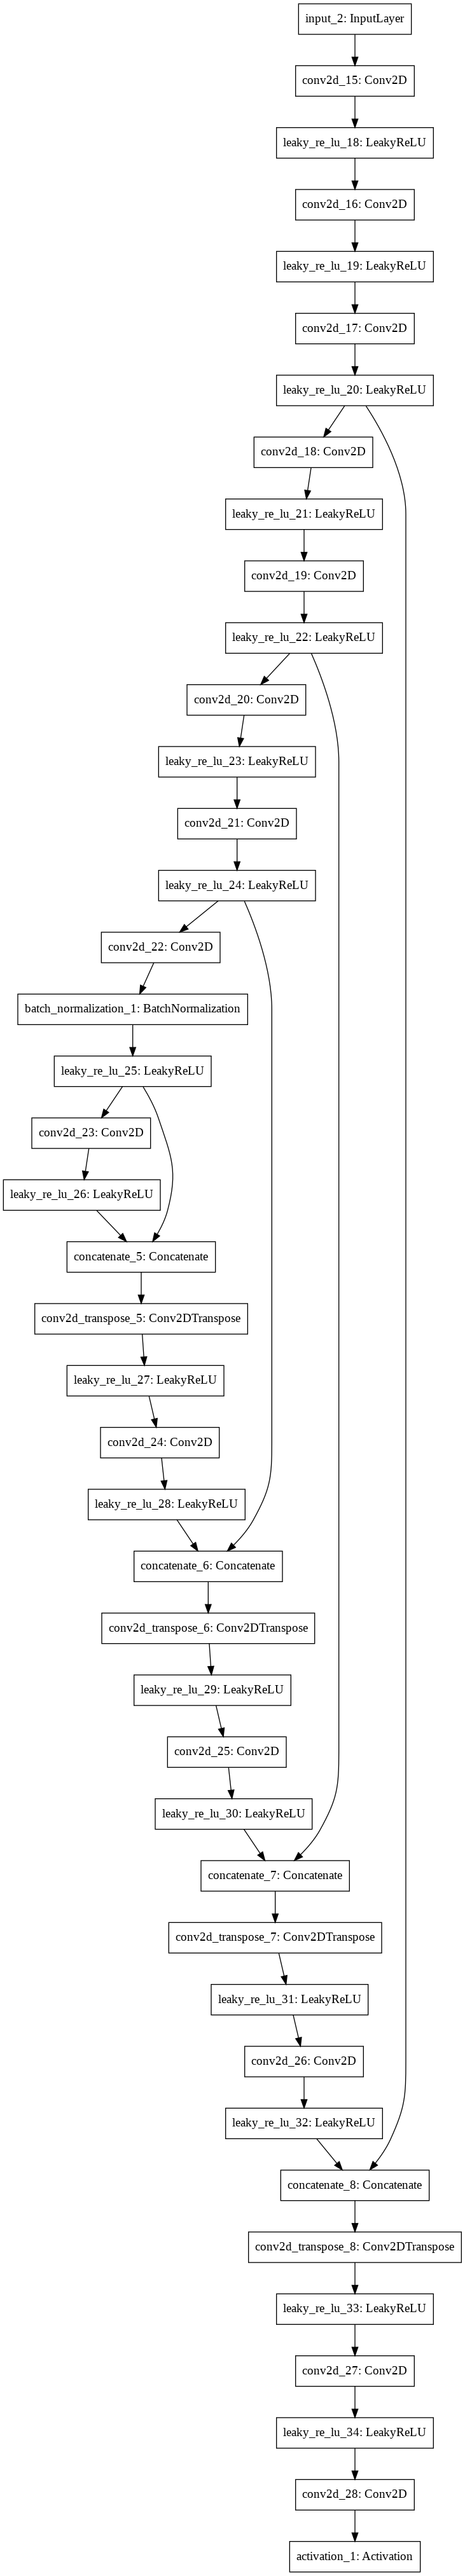

In [126]:
from IPython.display import Image, display_png

#学習モデル図の作成
plot_model(my_model, to_file='my_model.png')
display_png(Image('my_model.png'))

conv2d_transpose (Deconvolution)の概念図

（https://qiita.com/shngt/items/9c86e69e16ce6d61a0c6より引用）



![転置畳み込み　3x3（下）をもとにして，5x5(上）を作る様子](https://camo.qiitausercontent.com/83d6062eb3d0c6204e84772ebe3d280350a79822/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3130333038352f32306530653834352d663633312d313939352d643835652d6263333966363961653966382e676966)

In [0]:
my_model.compile(loss= 'mean_squared_error' ,#'binary_crossentropy',# ,#  #   # # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0),
              #optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

In [128]:
Xex = np.array([x[2] for x in train2])
Yex = np.array([y[3] for y in train2])

dsize = len(Xex)
batch_size = 25
epochs = 100

X1 = np.array(Xex).reshape(dsize,192*192).astype('float32')
X1 = X1/255
X1 = X1.reshape(-1,192,192,1)
Y1 = np.array(Yex).reshape(dsize,192*192)
Y1 = Y1/255
Y1 = Y1.reshape(-1,192,192,1)

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = my_model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.2, # 20 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 22s 27ms/step - loss: 0.0200 - acc: 0.9785 - val_loss: 0.0189 - val_acc: 0.9788
Epoch 2/100
800/800 [==============================] - 20s 24ms/step - loss: 0.0188 - acc: 0.9786 - val_loss: 0.0183 - val_acc: 0.9798
Epoch 3/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0183 - acc: 0.9801 - val_loss: 0.0178 - val_acc: 0.9805
Epoch 4/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0176 - acc: 0.9803 - val_loss: 0.0169 - val_acc: 0.9807
Epoch 5/100
800/800 [==============================] - 20s 24ms/step - loss: 0.0167 - acc: 0.9806 - val_loss: 0.0159 - val_acc: 0.9811
Epoch 6/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0156 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9817
Epoch 7/100
800/800 [==============================] - 20s 25ms/step - loss: 0.0148 - acc: 0.9818 - val_loss: 0.0143 - val_acc: 0.9826
Epoch 8/1

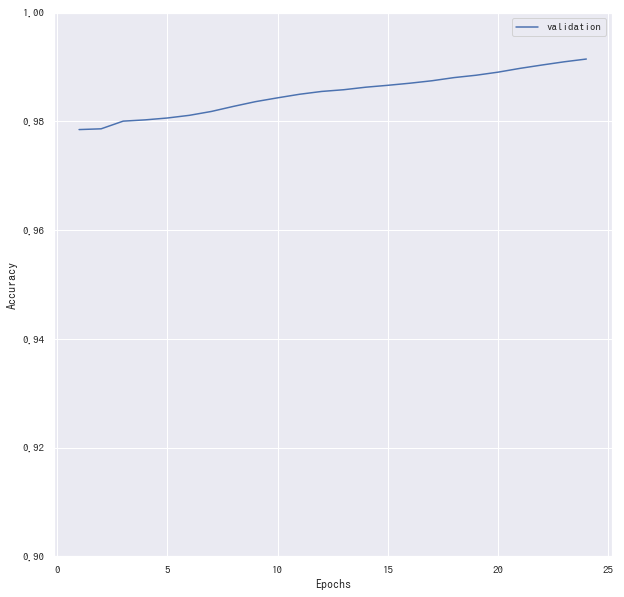

In [129]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

# テスト用データで検証

1.2889874
1.4445444
1.2888633
1.2998503
1.3333113


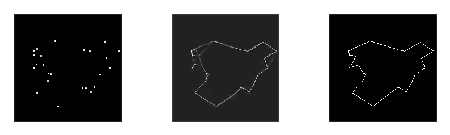

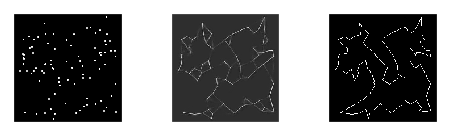

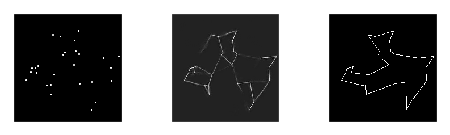

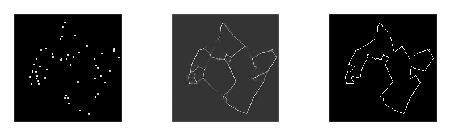

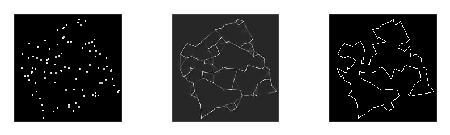

In [130]:
Xtex = np.array([x[2] for x in testdata2[:5]])
Ytex = np.array([y[3] for y in testdata2[:5]])

def test(X,Y,i):
    output = my_model.predict(X[i].reshape(-1,192,192,1)/255)
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(192,192)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X[i],cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    print(output.max())
    output = output
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y[i],cmap=plt.cm.binary)
for i in range(5):
    test(Xtex,Ytex,i)

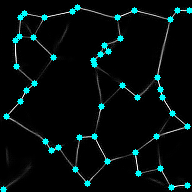

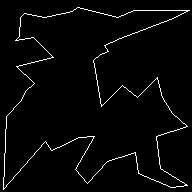

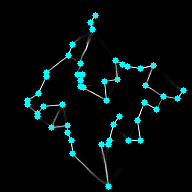

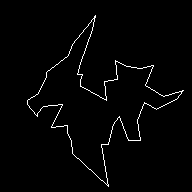

In [143]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
output = my_model.predict(train[99][2].reshape(-1,192,192,1)/255)
output = output.reshape(192,192)*255
color = cv2.cvtColor(output,cv2.COLOR_GRAY2BGR)
for [x,y] in train[99][0]:
        cv2.circle(color,(x,y),3,(255,255,0),-1)
cv2_imshow(cv2.resize(color,(192,192)))
print(" ")
cv2_imshow(cv2.resize(train[99][3],(192,192)))
print(" ")
output = my_model.predict(train2[99][2].reshape(-1,192,192,1)/255)
output = output.reshape(192,192)*255
color = cv2.cvtColor(output,cv2.COLOR_GRAY2BGR)
for [x,y] in train2[99][0]:
        cv2.circle(color,(x,y),3,(255,255,0),-1)
cv2_imshow(cv2.resize(color,(192,192)))
print(" ")
cv2_imshow(cv2.resize(train2[99][3],(192,192)))



---



# 最初に１回だけ実行すればよいコード（再掲）
以下は最初に１度だけ実行すればよいコードである。

In [0]:
# 巡回セールスマン問題の最適解を求めるためのライブラリ　導入
%cd /content
!git clone https://github.com/jvkersch/pyconcorde
% cd /content/pyconcorde
!pip install -e .

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
# 日本語フォントをダウンロードする。１度だけ実行
!apt-get -y install fonts-ipafont-gothic
# キャッシュを削除する。
!rm /root/.cache/matplotlib/fontlist-v300.json
# ランタイムを再起動する。